In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from score_sde.losses import get_optimizer
from score_sde.models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import score_sde.likelihood
import score_sde.controllable_generation
from score_sde.utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import score_sde.models
from score_sde.models import utils as mutils
from score_sde.models import ncsnpp
import score_sde.sampling
from score_sde.likelihood import get_likelihood_fn
from score_sde.sde_lib import VESDE, VPSDE, subVPSDE
from score_sde.sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import score_sde.datasets

/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-08 09:05:36.829580: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# @title Load the score-based model
from score_sde.configs.ve import ffhq_256_ncsnpp_continuous as configs
ckpt_filename = "../exp/ve/ffhq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

batch_size = 1
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0

sigmas = mutils.get_sigmas(config)
scaler = score_sde.datasets.get_data_scaler(config)
inverse_scaler = score_sde.datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [4]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(4, 4))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


# Predictor Corrector sampling


Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

In [10]:
sde.T

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


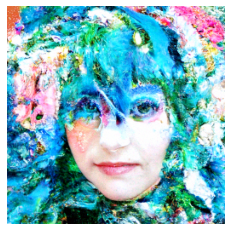

In [9]:
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = None #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.15 #@param {"type": "number"}
n_steps = 3 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = score_sde.sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)


In [13]:
torch.linspace(sde.T, sampling_eps, 2000)

tensor([1.0000e+00, 9.9950e-01, 9.9900e-01,  ..., 1.0105e-03, 5.1025e-04,
        9.9998e-06])

In [ ]:
torch.linspace(1, , 2000)

# Probability flow ODE

With black-box ODE solvers, we can produce samples, compute likelihoods, and obtain a uniquely identifiable encoding of any data point.

In [ ]:
 #@title ODE sampling

shape = (batch_size, 3, 32, 32)
sampling_fn = score_sde.sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
show_samples(x)

In [ ]:
#@title Likelihood computation
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=True, evaluation=True)
eval_iter = iter(eval_ds)
bpds = []
likelihood_fn = likelihood.get_likelihood_fn(sde,                                              
                                             inverse_scaler,                                             
                                             eps=1e-5)
for batch in eval_iter:
  img = batch['image']._numpy()
  img = torch.tensor(img).permute(0, 3, 1, 2).to(config.device)
  img = scaler(img)
  bpd, z, nfe = likelihood_fn(score_model, img)
  bpds.extend(bpd)
  print(f"average bpd: {torch.tensor(bpds).mean().item()}, NFE: {nfe}")

In [ ]:
#@title Representations
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=False, evaluation=True)
eval_batch = next(iter(eval_ds))
eval_images = eval_batch['image']._numpy()
shape = (batch_size, 3, 32, 32)

likelihood_fn = likelihood.get_likelihood_fn(sde, inverse_scaler, eps=1e-5)
sampling_fn = sampling.get_ode_sampler(sde, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps, device=config.device)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_grid(eval_images))
plt.title('Original images')

eval_images = torch.from_numpy(eval_images).permute(0, 3, 1, 2).to(config.device)
_, latent_z, _ = likelihood_fn(score_model, scaler(eval_images))

x, nfe = sampling_fn(score_model, latent_z)

x = x.permute(0, 2, 3, 1).cpu().numpy()
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_grid(x))
plt.title('Reconstructed images')

# Controllable generation

Several demonstrations on how to solve inverse problems with our SDE framework.

Recommended settings

| dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

In [ ]:
#@title PC inpainting
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)
batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)

mask = torch.ones_like(img)
mask[:, :, :, 16:] = 0.
show_samples(img * mask)


x = pc_inpainter(score_model, scaler(img), mask)
show_samples(x)

In [ ]:
#@title PC colorizer
train_ds, eval_ds, _ = datasets.get_dataset(config)
eval_iter = iter(eval_ds)
bpds = []

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

batch = next(eval_iter)
img = batch['image']._numpy()
img = torch.from_numpy(img).permute(0, 3, 1, 2).to(config.device)
show_samples(img)
gray_scale_img = torch.mean(img, dim=1, keepdims=True).repeat(1, 3, 1, 1)
show_samples(gray_scale_img)
gray_scale_img = scaler(gray_scale_img)
pc_colorizer = controllable_generation.get_pc_colorizer(
    sde, predictor, corrector, inverse_scaler,
    snr=snr, n_steps=n_steps, probability_flow=probability_flow,
    continuous=config.training.continuous, denoise=True
)
x = pc_colorizer(score_model, gray_scale_img)

show_samples(x)

## Class-conditional generation



Check out the [class-conditional generation section](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55#scrollTo=HiYRNB-Wk329&line=3&uniqifier=1) in our [JAX demo](https://colab.research.google.com/drive/1dRR_0gNRmfLtPavX2APzUggBuXyjWW55?usp=sharing)